In [158]:
import pandas as pd
import numpy as np

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model._stochastic_gradient import SGDClassifier

from hazm import word_tokenize
from hazm.Stemmer import Stemmer
from sklearn import preprocessing

from sklearn.feature_selection import chi2,SelectPercentile
from sklearn import svm
from sklearn.neighbors._classification import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble._weight_boosting import AdaBoostClassifier
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics._classification import f1_score,precision_score,recall_score

import pickle

import matplotlib.pyplot as plt

In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [49]:
nltk_stopwords = nltk.corpus.stopwords.words('english')

In [50]:
chars   = 'D:\\Project\\Scraping\\MehrNews\\StopwordFarsi\\chars.txt'
persian = 'D:\\Project\\Scraping\\MehrNews\\StopwordFarsi\\persian.txt'

In [51]:
with open(persian,encoding='utf8') as stopWords_file:
    stopwords = stopWords_file.readlines()
stopwords = [str(line).replace('\n', '') for line in stopwords]
with open(chars,encoding='utf8') as stopWords_file:
    stopwords = stopWords_file.readlines()
chars = [str(line).replace('\n', '') for line in stopwords]

In [52]:
nltk_stopwords.extend(stopwords)
nltk_stopwords.extend(chars)

In [53]:
files = ['Economy','Sport','Politics' ,'Health']
for file in files:
    locals()[file] = pd.read_json(f'D:\\Project\\Scraping\\MehrNews\\Data\\{file}.json')
    globals()[file]['category'] = file
df = pd.DataFrame()
for var in files:
    df = pd.concat([df,globals()[var]],ignore_index=True)

In [54]:
df.head()

,title,des,time,category
0,کارت سوخت در ۳۵۰۰ جایگاه فعال شد,مدیرعامل شرکت ملی پخش فرآورده‌های نفتی از اتصا...,1400-08-10,Economy
1,جریمه‌های سنگین در انتظار پرمصرف‌های برق است,مدیرعامل شرکت توانیر گفت: طبق پیشنهاد ارائه شد...,1400-08-10,Economy
2,جزئیات نرخ رسمی ۴۶ ارز/ افزایش قیمت ۲۲ ارز,بانک مرکزی امروز (دوشنبه دهم آبان ماه ۱۴۰۰) نر...,1400-08-10,Economy
3,آغاز اجرای سرشماری آزمایشی در ۵ منطقه کشور,رئیس مرکز آمار ایران گفت: از یکم آبان سرشماری ...,1400-08-10,Economy
4,بازگشایی مسیر شمال به جنوب آزادراه تهران- شمال,مرکز مدیریت راه‌های کشور از بازگشایی مسیر شمال...,1400-08-10,Economy


In [55]:
df.isnull().sum()

title       0
des         0
time        0
category    0
dtype: int64

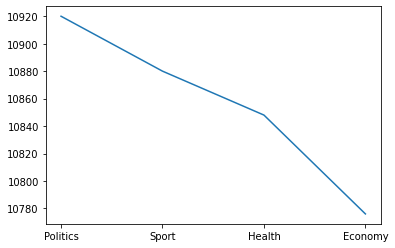

In [56]:
temp = pd.DataFrame(df.category.value_counts()).reset_index()
plt.plot(temp['index'],temp['category'])

In [57]:
stemmer = Stemmer()
dataset = pd.DataFrame(columns=('title_des','category'))

In [58]:
for index,row in df.iterrows():
    title_des = row['title'] +' '+row['des']
    title_des_tokenized = word_tokenize(title_des)
    title_des_tokenized_filtered = [w for w in title_des_tokenized if not w in nltk_stopwords]
    title_des_tokenized_filtered_stemming = [stemmer.stem(w) for w in title_des_tokenized_filtered]
    dataset.loc[index] = {'title_des':' '.join(title_des_tokenized_filtered_stemming),'category':row['category']}
dataset.head()

,title_des,category
0,کار سوخ در ۳۵۰۰ جایگاه فعال شد مدیرعامل شرک مل...,Economy
1,جریمه سنگین در انتظار پرمصرف برق اس مدیرعامل ش...,Economy
2,جزئ نرخ رسم ۴۶ ارز/ افزا قیم ۲۲ ارز بانک مرکز ...,Economy
3,آغاز اجرا سرشمار آزمایش در منطقه کشور رئیس مرک...,Economy
4,بازگشا مسیر شمال به جنوب آزادراه تهران- شمال م...,Economy


In [59]:
vectorizer = TfidfVectorizer(sublinear_tf=True,max_df=0.5)
train = vectorizer.fit(dataset['title_des']).transform(dataset['title_des'])

In [60]:
file = open('vectorizer.norouzi','ab')
pickle.dump(vectorizer,file)
file.close()

In [61]:
le = preprocessing.LabelEncoder()
y = le.fit(dataset['category']).transform(dataset['category'])

In [62]:
file = open('LabelEncoder.norouzi','ab')
pickle.dump(le,file)
file.close()

In [63]:
np.unique(dataset['category'])

array(['Economy', 'Health', 'Politics', 'Sport'], dtype=object)

In [64]:
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
for train_index,test_index in split.split(X,y):
    X_train,X_test = X[train_index] , X[test_index]
    y_train,y_test = y[train_index] , y[test_index]

In [65]:
ch2 = SelectPercentile(chi2,percentile=80)

In [66]:
X_train = ch2.fit_transform(X_train,y_train)
X_test = ch2.transform(X_test)

In [67]:
sgd = SGDClassifier()
sgd.fit(X_train,y_train)
score = sgd.score(X_test, y_test)
print(score)

0.9983880253310305


In [68]:
np.shape(X)

(43424, 5143)

In [69]:
sgd = SGDClassifier()
sgd.fit(X,y)
file = open('sgdAL.norouzi','ab')
pickle.dump(sgd,file)
file.close()

In [70]:
svmc = svm.SVC()
svmc.fit(X_train,y_train)
score = svmc.score(X_test, y_test)
print(score)

0.9997697179044329


In [71]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
score = knn.score(X_test, y_test)
print(score)

0.9989637305699481


In [72]:
mnnb = MultinomialNB()
mnnb.fit(X_train,y_train)
score = mnnb.score(X_test, y_test)
print(score)

0.9795048934945308


In [73]:
abd = AdaBoostClassifier()
abd.fit(X_train,y_train)
score = abd.score(X_test, y_test)
print(score)

0.8563039723661485
